We consider a simple fluid of particles that interact due to the Lennard Jones potential

$$
U(r) = 4\varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right]
$$

To validate the integration of the diffusion process and correct implementation of energies and forces, we compare observables to other known results. The observables are: the mean potential energy of the system per particle $U$,  the pressure $P$ and the radial distribution function $g(r)$.

The thermodynamic quantities of a Lennard Jones fluid are typically expressed in terms of the rescaled density
$\rho^* = (N/V)\sigma^3$ and the rescaled temperature $T^* = k_BT/\varepsilon$, where $N$ is the number of particles in the system, which is constant over time, and $V$ is the available volume.
In simulation practice we set $\sigma=1$ and $\varepsilon=1$ to achieve the reduced units. The time units are $\sigma^2 / 4D$, where $D$ is the self diffusion coefficient of the particles. Hence in practice we set the diffusion coefficient to 1 and have a fully rescaled unit system.

We use an Euler scheme to integrate the positions of particles according to the overdamped Langevin equation of motion, in contrast to a full integration of positions and momenta as in the underdamped limit.

The pressure can be measured from the acting forces according to [4].

$$
PV = Nk_BT + \langle \mathscr{W} \rangle
$$

where

$$
\mathscr{W} = \frac{1}{3} \sum_i \sum_{j>i} \mathbf{r}_{ij} \mathbf{f}_{ij},
$$

This is implemented by ReaDDy's pressure observable.

__Results__

| origin | cutoff radius $r_c$ | density $\rho$ | temperature $T$ | pressure $P$ | potential energy per particle $U$ |
|---|---|---|---|---|---|
|[1]|4|0.3|3|1.023(2)|-1.673(2)|
|[2]|4|0.3|3|1.0245|-1.6717|
|HALMD [3]|4|0.3|3|1.0234(3)|-1.6731(4)|
|ReaDDy|4|0.3|3|--- *|-1.668(7)|
|||||||
|[1]|4|0.6|3|3.69(1)|-3.212(3)|
|[2]|4|0.6|3|3.7165|-3.2065|
|HALMD [3]|4|0.6|3|3.6976(8)|-3.2121(2)|
|ReaDDy|4|0.6|3|--- *|-3.200(9)|

[1] Molecular dynamics simulations, J. K. Johnson, J. A. Zollweg, and K. E. Gubbins,
The Lennard-Jones equation of state revisited, Mol. Phys. 78, 591 (1993)

[2] Integral equations theory, A. Ayadim, M. Oettel, and S Amokrane,
Optimum free energy in the reference functional approach for the integral equations theory, J. Phys.: Condens. Matter 21, 115103 (2009).

[3] HAL's MD package, http://halmd.org/validation.html

[4] Allen, M. P., & Tildesley, D. J. (1987). Computer Simulation of Liquids. New York: Oxford University Press.

In [1]:
import os
import numpy as np

import readdy
print(readdy.__version__)

86-1234567


/home/chris/miniconda3/envs/tutorials/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Utility methods

In [2]:
def average_across_first_axis(values):
    n_values = len(values)
    mean = np.sum(values, axis=0) / n_values  # shape = n_bins
    difference = values - mean  # broadcasting starts with last axis
    std_dev = np.sqrt(np.sum(difference * difference, axis=0) / n_values)
    std_err = np.sqrt(np.sum(difference * difference, axis=0) / n_values ** 2)
    return mean, std_dev, std_err


def lj_system(edge_length, temperature=1.):
    system = readdy.ReactionDiffusionSystem(
        box_size=[edge_length, edge_length, edge_length],
        unit_system=None
    )
    system.kbt = temperature
    system.add_species("A", diffusion_constant=1.)
    system.potentials.add_lennard_jones("A", "A", m=12, n=6, epsilon=1., sigma=1., cutoff=4., shift=True)
    return system

Wrap the whole simulation and analysis in a function and perform it for the two densities 0.3 and 0.6.

In [3]:
def equilibrate_and_measure(density=0.3):
    n_per_axis = 12
    n_particles = n_per_axis ** 3
    edge_length = (n_particles / density) ** (1. / 3.)
    pos_x = np.linspace(-edge_length/2., edge_length/2.-1., n_per_axis)
    pos = []
    for x in pos_x:
        for y in pos_x:
            for z in pos_x:
                pos.append([x,y,z])
    pos = np.array(pos)
    print("n_particles", len(pos), "box edge_length", edge_length)
    assert len(pos)==n_particles
    
    def pos_callback(x):
        nonlocal pos
        n = len(x)
        pos = np.zeros((n,3))
        for i in range(n):
            pos[i][0] = x[i][0]
            pos[i][1] = x[i][1]
            pos[i][2] = x[i][2]
        print("saved positions")
    
    # create system
    system = lj_system(edge_length, temperature=3.)
    
    # equilibrate
    sim = system.simulation(kernel="CPU")
    sim.add_particles("A", pos)

    sim.observe.particle_positions(2000, callback=pos_callback, save=None)
    sim.observe.energy(500, callback=lambda x: print(x), save=None)

    sim.record_trajectory(stride=1)
    sim.output_file = "lj_eq.h5"
    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)

    sim.run(n_steps=10000, timestep=1e-4)

    traj = readdy.Trajectory(sim.output_file)
    traj.convert_to_xyz(particle_radii={"A": 0.5})
    
    # measure
    sim = system.simulation(kernel="CPU")
    sim.add_particles("A", pos)
    sim.observe.energy(200)
    sim.observe.pressure(200)
    sim.observe.rdf(
        200, bin_borders=np.linspace(0.5, 4., 50),
        types_count_from="A", types_count_to="A", particle_to_density=density)

    sim.output_file = "lj_measure.h5"
    if os.path.exists(sim.output_file):
        os.remove(sim.output_file)

    sim.run(n_steps=10000, timestep=1e-4)
    
    # obtain results
    traj = readdy.Trajectory(sim.output_file)
    _, energy = traj.read_observable_energy()
    _, bin_centers, rdf = traj.read_observable_rdf()
    _, pressure = traj.read_observable_pressure()
    
    energy_mean, _, energy_err = average_across_first_axis(energy) # time average
    energy_mean /= n_particles
    energy_err /= n_particles

    pressure_mean, _, pressure_err = average_across_first_axis(pressure) # time average

    rdf_mean, _, rdf_err = average_across_first_axis(rdf) # time average

    return {
        "energy_mean": energy_mean, "energy_err": energy_err,
        "pressure_mean": pressure_mean, "pressure_err": pressure_err,
        "rdf_mean": rdf_mean, "rdf_err": rdf_err, "rdf_bin_centers": bin_centers
    }

In [4]:
result_low_dens = equilibrate_and_measure(density=0.3)

n_particles 1728 box edge_length 17.925618986228656
Configured kernel context with:
--------------------------------
 - kBT = 3
 - periodic b.c. = (true, true, true)
 - box size = (17.9256, 17.9256, 17.9256)
 - particle types:
     *  particle type "A" with D=1
 - potentials of order 2:
     * for types "A" and "A"
         * 12-6-Lennard-Jones potential with cutoff=4, epsilon=1, k=4, and with energy shift



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

saved positions
-2006.0926382760322
-2622.8761401382144
-2788.959874718062
-2788.1858998180633
saved positions
-2841.400538210281
-2959.928045257567
-2876.4611642522195
-2993.33155002436
saved positions
-2836.7776897147037
-2946.2830287478305
-2899.8887540283704
-2846.3360349249842
saved positions
-2850.5906091718102
-2921.989435254799
-2845.1244627422743
-2846.496759060629
saved positions
-2870.7215525792976
-2870.560311314554
-2949.401154719958
-2875.522397485467
saved positions
-2899.6706721326827
Configured kernel context with:
--------------------------------
 - kBT = 3
 - periodic b.c. = (true, true, true)
 - box size = (17.9256, 17.9256, 17.9256)
 - particle types:
     *  particle type "A" with D=1
 - potentials of order 2:
     * for types "A" and "A"
         * 12-6-Lennard-Jones potential with cutoff=4, epsilon=1, k=4, and with energy shift



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [5]:
result_low_dens

{'energy_err': 0.003456790786372574,
 'energy_mean': -1.6688324044596774,
 'pressure_err': 0.093940555098919,
 'pressure_mean': 0.7248811823605257,
 'rdf_bin_centers': array([0.53571429, 0.60714286, 0.67857143, 0.75      , 0.82142857,
        0.89285714, 0.96428571, 1.03571429, 1.10714286, 1.17857143,
        1.25      , 1.32142857, 1.39285714, 1.46428571, 1.53571429,
        1.60714286, 1.67857143, 1.75      , 1.82142857, 1.89285714,
        1.96428571, 2.03571429, 2.10714286, 2.17857143, 2.25      ,
        2.32142857, 2.39285714, 2.46428571, 2.53571429, 2.60714286,
        2.67857143, 2.75      , 2.82142857, 2.89285714, 2.96428571,
        3.03571429, 3.10714286, 3.17857143, 3.25      , 3.32142857,
        3.39285714, 3.46428571, 3.53571429, 3.60714286, 3.67857143,
        3.75      , 3.82142857, 3.89285714, 3.96428571]),
 'rdf_err': array([0.        , 0.        , 0.        , 0.        , 0.00035392,
        0.00357092, 0.00724873, 0.00873965, 0.01206437, 0.00894255,
        0.008646

In [9]:
result_hi_dens = equilibrate_and_measure(density=0.6)

n_particles 1728 box edge_length 14.227573217960249
Configured kernel context with:
--------------------------------
 - kBT = 3
 - periodic b.c. = (true, true, true)
 - box size = (14.2276, 14.2276, 14.2276)
 - particle types:
     *  particle type "A" with D=1
 - potentials of order 2:
     * for types "A" and "A"
         * 12-6-Lennard-Jones potential with cutoff=4, epsilon=1, k=4, and with energy shift



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

saved positions
-6881.589189746084
-5656.8105995622955
-5567.390116611299
-5526.605841927836
saved positions
-5573.575452954913
-5641.07443929333
-5504.676720552814
-5511.70540202274
saved positions
-5509.237870145425
-5639.583772756297
-5629.039566460307
-5563.755682820279
saved positions
-5461.171806102469
-5616.038877692792
-5529.960573612284
-5521.704207468562
saved positions
-5548.544392414856
-5676.650120392681
-5491.82164389591
-5521.771911491108
saved positions
-5565.317042448245
Configured kernel context with:
--------------------------------
 - kBT = 3
 - periodic b.c. = (true, true, true)
 - box size = (14.2276, 14.2276, 14.2276)
 - particle types:
     *  particle type "A" with D=1
 - potentials of order 2:
     * for types "A" and "A"
         * 12-6-Lennard-Jones potential with cutoff=4, epsilon=1, k=4, and with energy shift



HBox(children=(HBox(children=(Label(value='Simulation progress'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=1000), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

In [11]:
result_hi_dens

{'energy_err': 0.006769509617449894,
 'energy_mean': -3.2116253580419536,
 'pressure_err': 0.007171212637390889,
 'pressure_mean': 1.2323604375943777,
 'rdf_err': array([0.        , 0.        , 0.        , 0.        , 0.00032419,
        0.0037992 , 0.0065596 , 0.00738094, 0.00651913, 0.00618312,
        0.00598792, 0.0051374 , 0.00502749, 0.00330874, 0.00344011,
        0.00364512, 0.00337134, 0.00347608, 0.00306173, 0.00335394,
        0.00350444, 0.00296715, 0.00367411, 0.00362624, 0.00265353,
        0.00302284, 0.00252535, 0.00302462, 0.00209401, 0.00247465,
        0.00214554, 0.00238694, 0.00247292, 0.00230585, 0.00256749,
        0.00231343, 0.00212761, 0.00211549, 0.00199801, 0.00207221,
        0.00200445, 0.00160165, 0.00186969, 0.00160319, 0.00185383,
        0.00176429, 0.00165519, 0.00149458, 0.00155715]),
 'rdf_mean': array([0.        , 0.        , 0.        , 0.        , 0.00218443,
        0.21063654, 1.08677454, 1.71990746, 1.72065572, 1.50473499,
        1.28965171, 

mean energy per particle {0.3: -1.6678671765797455, 0.6: -3.1995739684456534}
err energy per particle {0.3: 0.0065533260241699481, 0.6: 0.0089460121350560928}


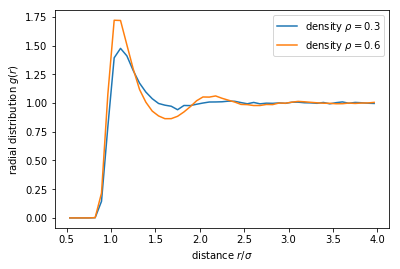

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

print("density 0.3:")
print("mean energy per particle {}\nerr energy per particle {}".format(
    result_low_dens["energy_mean"], result_low_dens["energy_err"]))
print("pressure {}\nerr pressure {}".format(
    result_low_dens["pressure_mean"], result_low_dens["pressure_err"]))
print("density 0.6:")
print("mean energy per particle {}\nerr energy per particle {}".format(
    result_hi_dens["energy_mean"], result_hi_dens["energy_err"]))
print("pressure {}\nerr pressure {}".format(
    result_hi_dens["pressure_mean"], result_hi_dens["pressure_err"]))

plt.plot(result_low_dens["rdf_bin_centers"], result_low_dens["rdf_mean"], label=r"density $\rho=0.3$")
plt.plot(result_hi_dens["rdf_bin_centers"], result_hi_dens["rdf_mean"], label=r"density $\rho=0.6$")
plt.xlabel(r"distance $r/\sigma$")
plt.ylabel(r"radial distribution $g(r)$")
plt.legend(loc="best")
plt.show()